# Summary

#### Aim: 
To identify meaningful segments of Australian voters based on socio-demographic data, political attitudes, and issue priorities using clustering techniques. Build and evaluate multi-class classification models to predict whether a voter supports the Labor Party, the Coalition, or a minor/independent party (Other).

#### Data:
- **Source:** The [Australian Election Study](https://dataverse.ada.edu.au/dataset.xhtml?persistentId=doi:10.26193/W3U2S3), conducted by the School of Politics and International Relations of the Australian National University. 
- **Dataset:** aes22_unrestricted_v3.csv. Voter's survey data that examines important issues such as changing support for political parties, the role of the party leaders and the importance of political issues like the economy and the environment. Only 29 of the over 350 features in the dataset were used in this analysis and the data dictionary for these can be found in the documentation's apendix.

#### Method:
- EDA: Univariate data analysis, bivariate data analysis, grouping and aggregates.
- Fuzzy c-means clustering on subsets of data with features grouped by themes (Demographics, Political engagement and attitudes, Government spending, Important issues). Variables encoded with MinMaxScaler and One-Hot encoding. Optimal number of clusters based on Fuzzy Partition Coefficient (FPC).
- Multinomial Logistic Regression with best features determined by recursive feature selection. Optimal decision thresholds identified with ROC curves.
- Random Forest classifier with hyperparameter tuning using GridSearchCV.
- XGB Boost classifier with hyperparameter tuning using GridSearchCV.

#### Results and findings:
- Logistic Regression was the most interpretable model and clearly showed how features like spending preferences and demographics relate to vote choice.

- It struggled to predict "Other" voters, even after tuning thresholds, and had lower overall accuracy.

- Random Forest improved recall for "Other" voters and picked up on more complex, non-linear patterns, especially for label-encoded variables.

- XGBoost performed best overall:

    - Achieved the highest accuracy (61%) and the most balanced classification across all three voter groups.

    - Had the best ROC AUC scores, especially for Coalition voters (0.86).

- All models showed that predicting individual voting behavior is inherently difficult, but they still revealed meaningful patterns and distinctions between voter segments.

- Clustering analysis identified distinct voter groups based on age, income, education, residence, and issue priorities.

- Predictive models reinforced these clusters:

 - Key features like age_group, social_class, top_issue, and spend_ variables were important across both approaches.

- Logistic regression explained high-level ideological divides (e.g., Coalition vs Labor).

- Tree-based models (RF and XGB) were better at identifying "Other" voters, capturing more subtle or complex patterns.

- Feature importance rankings differed:

 - Tree models ranked top_issue much higher, showing their strength in handling non-linear interactions.

- Both methods agreed on the broader takeaway: voter behavior is structured but complex, and no single model can fully predict it.

#### Future improvements or considerations:
- Expand feature set: This project used a carefully selected subset of the 2022 AES survey. Future work could explore additional variables (e.g., media use, political knowledge, trust in institutions, policy-specific attitudes) to capture more nuanced drivers of voting behavior.

- Obtain more samples from younger voters.

- Longitudinal analysis: The AES has been conducted after every federal election since 1987. Comparing voter behavior across multiple election cycles could reveal trends over time, such as shifting demographics, evolving party support, or the long-term impact of political events.


# Data Dictionary

# 1. Reading data and EDA

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
from matplotlib.colors import LinearSegmentedColormap

# Define a custom palette to use in notebook
custom_palette = sns.color_palette(["#124067","#0ea599", "#e1b510", "#de7b02", "#1f5d4d"])

In [2]:
columns_list = ["STATE","H1","J4","J5","J6","H2_AGE_GRP1","G3_EDU","A1",
                "A10","B1","B2","B3","B9_1", "B16","B17","C5","C7","D3_1","D3_2","D8_1","D8_2",
                "D8_3","D8_4","D8_5","D8_6","D8_7","D8_8","D8_9","D8_10"]
data = pd.read_csv("aes22_unrestricted_v3.csv", usecols=columns_list)
data.head()

,STATE,A1,A10,B1,B2,B3,B9_1,B16,B17,C5,...,D8_7,D8_8,D8_9,D8_10,H1,J4,J5,J6,H2_AGE_GRP1,G3_EDU
0,5,2,1,2,2,1,2,2,2,2,...,2,2,2,2,1,3,5,15,3,1
1,5,2,2,95,,2,1,4,2,2,...,2,3,3,4,1,3,2,24,4,2
2,5,1,1,1,1,1,1,2,2,2,...,2,2,2,3,1,2,5,21,3,1
3,5,1,1,1,3,1,2,2,1,2,...,3,2,3,3,2,2,4,25,4,2
4,5,1,1,3,2,1,3,3,1,1,...,3,3,3,3,1,3,1,21,4,2


In [3]:
rename_dict = {
    "STATE": "state",
    "A1": "political_interest",
    "A10": "vote_if_not_compulsory",
    "B1": "party_id",
    "B2":"party_support_strength",
    "B3": "care_who_wins",
    "B9_1": "first_pref_vote",
    "B16": "party_cares_about_people",
    "B17": "parties_needed",
    "C5": "satisfaction_democracy",
    "C7": "gov_for_people",
    "D3_1": "top_issue",
    "D3_2": "second_issue",
    "D8_1": "spend_health",
    "D8_2": "spend_education",
    "D8_3": "spend_unemployment",
    "D8_4": "spend_defence",
    "D8_5": "spend_pensions",
    "D8_6": "spend_industry",
    "D8_7": "spend_police",
    "D8_8": "spend_ndis",
    "D8_9": "spend_transport",
    'D8_10': 'spend_childcare',
    "H1": "gender",
    "J4": "social_class",
    "J5": "residence_type",
    "J6": "household_income",
    "H2_AGE_GRP1": "age_group",
    "G3_EDU": "has_uni_degree"
}

data.rename(columns=rename_dict, inplace=True)
data.columns

Index(['state', 'political_interest', 'vote_if_not_compulsory', 'party_id',
       'party_support_strength', 'care_who_wins', 'first_pref_vote',
       'party_cares_about_people', 'parties_needed', 'satisfaction_democracy',
       'gov_for_people', 'top_issue', 'second_issue', 'spend_health',
       'spend_education', 'spend_unemployment', 'spend_defence',
       'spend_pensions', 'spend_industry', 'spend_police', 'spend_ndis',
       'spend_transport', 'spend_childcare', 'gender', 'social_class',
       'residence_type', 'household_income', 'age_group', 'has_uni_degree'],
      dtype='object')

## 1.1 Basic Structure and summary

In [4]:
data.shape

(2508, 29)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2508 entries, 0 to 2507
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   state                     2508 non-null   int64 
 1   political_interest        2508 non-null   int64 
 2   vote_if_not_compulsory    2508 non-null   int64 
 3   party_id                  2508 non-null   int64 
 4   party_support_strength    2508 non-null   object
 5   care_who_wins             2508 non-null   int64 
 6   first_pref_vote           2508 non-null   object
 7   party_cares_about_people  2508 non-null   int64 
 8   parties_needed            2508 non-null   int64 
 9   satisfaction_democracy    2508 non-null   int64 
 10  gov_for_people            2508 non-null   int64 
 11  top_issue                 2508 non-null   int64 
 12  second_issue              2508 non-null   object
 13  spend_health              2508 non-null   int64 
 14  spend_education         

In [6]:
# Fill in spaces with NaNs
data.replace(" ",np.nan, inplace=True)

# Find columns with object data type
object_columns = data.select_dtypes(include=['object']).columns

# Convert object columns to Int64
data[object_columns] = data[object_columns].apply(pd.to_numeric, errors='coerce').astype('Int64')

# Convert all integer columns to Int64 for consistency
int_columns = data.select_dtypes(include=['int64']).columns
data[int_columns] = data[int_columns].astype('Int64')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2508 entries, 0 to 2507
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   state                     2508 non-null   Int64
 1   political_interest        2508 non-null   Int64
 2   vote_if_not_compulsory    2508 non-null   Int64
 3   party_id                  2508 non-null   Int64
 4   party_support_strength    2092 non-null   Int64
 5   care_who_wins             2508 non-null   Int64
 6   first_pref_vote           2494 non-null   Int64
 7   party_cares_about_people  2508 non-null   Int64
 8   parties_needed            2508 non-null   Int64
 9   satisfaction_democracy    2508 non-null   Int64
 10  gov_for_people            2508 non-null   Int64
 11  top_issue                 2508 non-null   Int64
 12  second_issue              2477 non-null   Int64
 13  spend_health              2508 non-null   Int64
 14  spend_education           2508 non-null 

## 1.2 Missing and special values

In [7]:
# Replacing skipped (999) and non-applicable (997) items with NaNs
data.replace({997: np.nan, 999: np.nan}, inplace=True)

data.isnull().sum()

state                         0
political_interest            2
vote_if_not_compulsory        6
party_id                     11
party_support_strength      422
care_who_wins                10
first_pref_vote              73
party_cares_about_people     17
parties_needed               38
satisfaction_democracy        9
gov_for_people               27
top_issue                    30
second_issue                 79
spend_health                 39
spend_education              40
spend_unemployment           45
spend_defence                43
spend_pensions               44
spend_industry               52
spend_police                 47
spend_ndis                   49
spend_transport              51
spend_childcare              46
gender                       45
social_class                 70
residence_type               75
household_income            184
age_group                    83
has_uni_degree               66
dtype: int64

In [8]:
# Number of people not elegible to vote
data[data["vote_if_not_compulsory"]== 97].shape[0]

14

Note: given that this analysis aims to investigate and predict voting patterns, these non-voters will not contribute to the analysis and will be dropped.

In [9]:
# Count the number of NaNs in each row
nan_counts = data.isnull().sum(axis=1)

# Find the rows missing more than 20% of the values
nan_rows = data[nan_counts >= 6]
                
# Print the total number of rows 
print(f"Total rows with more than 20% NaNs: {nan_rows.shape[0]}")

Total rows with more than 20% NaNs: 66


In [10]:
# Dropping rows with more than 20% NaNs
data = data.drop(index = nan_counts[nan_counts >= 6].index)

# Dropping rows with non-voters
data = data.drop(data[data["vote_if_not_compulsory"]== 97].index)

# check final shape
data.shape

(2430, 29)

In [11]:
data.isnull().sum()

state                         0
political_interest            2
vote_if_not_compulsory        6
party_id                      7
party_support_strength      395
care_who_wins                10
first_pref_vote              48
party_cares_about_people      8
parties_needed               27
satisfaction_democracy        5
gov_for_people               17
top_issue                    13
second_issue                 56
spend_health                  4
spend_education               3
spend_unemployment            6
spend_defence                 4
spend_pensions                6
spend_industry               10
spend_police                  6
spend_ndis                   10
spend_transport              13
spend_childcare               8
gender                        9
social_class                 31
residence_type               35
household_income            137
age_group                    44
has_uni_degree               27
dtype: int64

In [12]:
# Imputing low missing counts of categorical variables with the mode
mode_vars = ['party_id','first_pref_vote','top_issue', 'second_issue',
       'gender', 'social_class','residence_type','age_group','has_uni_degree']

mode_imputer = SimpleImputer(strategy='most_frequent')
data[mode_vars] = mode_imputer.fit_transform(data[mode_vars])

# Imputing low missing counts of ordinal variables with the median
median_vars = ['political_interest', 'vote_if_not_compulsory','care_who_wins', 
       'party_cares_about_people', 'parties_needed','satisfaction_democracy', 'gov_for_people', 
       'spend_health', 'spend_education', 'spend_unemployment',
       'spend_defence', 'spend_pensions', 'spend_industry', 'spend_police',
       'spend_ndis', 'spend_transport', 'spend_childcare']

median_imputer = SimpleImputer(strategy='median')
data[median_vars] = median_imputer.fit_transform(data[median_vars])

data.isnull().sum()

state                         0
political_interest            0
vote_if_not_compulsory        0
party_id                      0
party_support_strength      395
care_who_wins                 0
first_pref_vote               0
party_cares_about_people      0
parties_needed                0
satisfaction_democracy        0
gov_for_people                0
top_issue                     0
second_issue                  0
spend_health                  0
spend_education               0
spend_unemployment            0
spend_defence                 0
spend_pensions                0
spend_industry                0
spend_police                  0
spend_ndis                    0
spend_transport               0
spend_childcare               0
gender                        0
social_class                  0
residence_type                0
household_income            137
age_group                     0
has_uni_degree                0
dtype: int64

In [13]:
# replacing NaNs in party_support_strength as missing to include them in study
data['party_support_strength'] = data['party_support_strength'].fillna(4)  #  0 = "missing"

# replacing NaNs in household_income with median of data grouped by related features
data['household_income'] = data.groupby(['age_group', 'has_uni_degree',
                                         "social_class"])['household_income'].transform(lambda x: x.fillna(round(x.median()))
                                        .astype("Int64"))

data.isnull().sum()

state                       0
political_interest          0
vote_if_not_compulsory      0
party_id                    0
party_support_strength      0
care_who_wins               0
first_pref_vote             0
party_cares_about_people    0
parties_needed              0
satisfaction_democracy      0
gov_for_people              0
top_issue                   0
second_issue                0
spend_health                0
spend_education             0
spend_unemployment          0
spend_defence               0
spend_pensions              0
spend_industry              0
spend_police                0
spend_ndis                  0
spend_transport             0
spend_childcare             0
gender                      0
social_class                0
residence_type              0
household_income            0
age_group                   0
has_uni_degree              0
dtype: int64

In [14]:
# Changing party_id and first_pref_vote to 1 = Coalition(Liberal+National), 2 = Labor and 3 = Other
data["party_id"]=np.where(data["party_id"]== 3, 1 , data["party_id"])       # Adding Nationals to Coalition
data["first_pref_vote"]=np.where(data["first_pref_vote"]== 3, 1, data["first_pref_vote"])

data["party_id"]=np.where(data["party_id"] > 3, 3, data["party_id"])        # Everyone else is a minor party or independent
data["first_pref_vote"]=np.where(data["first_pref_vote"]> 3, 3, data["first_pref_vote"])

In [15]:
# Re-mapping household_income to five brackets similar to income tax table

# Define new brackets
income_brackets = [
    data['household_income'] <= 1,  # under $15000
    (data['household_income'] > 1) & (data['household_income'] <= 7),  # $15001 to $45000
    (data['household_income'] > 7) & (data['household_income'] <= 15),  # $45001 to $120000
    (data['household_income'] > 15) & (data['household_income'] <= 21),  # $120001 to $200000
    data['household_income'] > 21  # over $200001
]

# Define the corresponding values for each category
values = [1, 2, 3, 4, 5]

# Apply the conditions to create the new categories
data['household_income'] = np.select(income_brackets, values, default=np.nan)

# Check the result
print(data['household_income'].value_counts().sort_index())

household_income
1.0      82
2.0     535
3.0    1053
4.0     456
5.0     304
Name: count, dtype: int64


In [16]:
# Making first_pref_vote the last column as future target variable
data = data[[col for col in data.columns if col != 'first_pref_vote'] + ['first_pref_vote']]

# Saving a copy of clean dataset for backup an modelling
data.to_csv("aes22_v3_cleaned.csv", index = False)

## 1.3 Univariate data analysis

In [17]:
# Creating label dictionaries to ease visualization

state_labels = {
    1:	"NSW",
    2:	"VIC",
    3:	"QLD",
    4:	"SA",
    5:	"WA",
    6:	"TAS",
    7:	"NT",
    8:	"ACT"
}

interest_labels = {
    1: "A good deal",
    2: "Some",
    3: "Not much",
    4: "None"
}

would_vote_labels = {
    1: "Definitely",
    2: "Probably",
    3: "Might",
    4: "Probably not",
    5: "Definitely not"
}

party_labels = {
    1: "Coalition",
    2: "Labor",
    3: "Other"
}

parties_care_labels = {
    1: "Care",
    2: "2",
    3: "3",
    4: "4",
    5: "Don't care"
}

parties_needed_labels = {
    1: "Necessary",
    2: "2",
    3: "3",
    4: "4",
    5: "Not needed"
}

support_labels = {
    1: "Very strong",
    2: "Fairly strong",
    3: "Not very strong",
    4: "Missing"
}

care_labels = {
    1:	"A good deal",
    2:	"Not very much",
    3:	"Not at all"
}

gov_people_labels = {
    1: "Entirely for big interests",
    2: "Mostly for big interests",
    3: "Half and hald",
    4: "Mostly for people",
    5: "Entirely for people"
}

income_labels = {
    1: "Under $15k",
    2: "$15k-$45k",
    3: "$45k-$120k",
    4: "$120k-$200k",
    5: "Over $200k"
}

spend_labels = {
    1: "Much more",
    2: "Somewhat more",
    3: "Same",
    4: "Somewhat less",
    5: "Much less"
}

gender_labels = {
    1: "Male",
    2: "Female",
    3: "Other"
}

class_labels = {
    1: "Upper",
    2: "Middle",
    3: "Working",
    4: "None"
}

residence_labels = {
    1: "Rural",
    2: "Small country town",
    3: "Larger country town",
    4: "Large town",
    5: "Major city"
}

age_labels = {
    1: "18 to 34",
    2: "35 to 44",
    3: "45 to 54",
    4: "Over 55"
}

uni_labels = {
    1: "Uni",
    2: "Non-Uni",
}

issues_labels = {
    1:	"Taxation",
    2:	"Immigration",
    3:	"Education",
    4:	"Environment",
    6:	"Health & Medicare",
    7:	"Asylum seekers",
    8:	"Global warming",
    10:	"The Economy",
    11:	"COVID-19 pandemic",
    12:	"Cost of living",
    13:	"National security"
}

satisfaction_labels = {
    1: "Very satisfied",
    2: "Fairly satisfied",
    3: "Not very satisfied",
    4: "Not at all satisfied",
}

# Create a labels dictionary
labels_dict = {
    "state": state_labels,
    "political_interest": interest_labels,
    "vote_if_not_compulsory": would_vote_labels,
    "party_id": party_labels,
    "party_support_strength": support_labels,
    "care_who_wins": care_labels,
    "party_cares_about_people": parties_care_labels,
    "parties_needed": parties_needed_labels,
    "satisfaction_democracy": satisfaction_labels,
    "gov_for_people": gov_people_labels,
    "top_issue": issues_labels,
    "second_issue": issues_labels,
    "spend_health": spend_labels,
    "spend_education": spend_labels,
    "spend_unemployment": spend_labels,
    "spend_defence": spend_labels,
    "spend_pensions": spend_labels,
    "spend_industry": spend_labels,
    "spend_police": spend_labels,
    "spend_ndis": spend_labels,
    "spend_transport": spend_labels,
    "spend_childcare": spend_labels,
    "gender": gender_labels,
    "social_class": class_labels,
    "residence_type": residence_labels,
    "household_income": income_labels,
    "age_group": age_labels,
    "has_uni_degree": uni_labels,
    "first_pref_vote": party_labels
}   

# Create a list of titles for countplots of each column
titles = [
    "Voters by state",
    "Level of political interest",
    "Would vote if not compulsory",
    "Identifies with this party",
    "Party support strength",
    "Care who wins the election",
    "Do parties care about people?",
    "Are parties needed?",
    "Satisfaction with democracy",
    "Is the Government run for the people?",
    "Top election issue",
    "Second election issue",
    "Should goverment spend more on health?",
    "Should goverment spend more on education?",
    "Should goverment spend more on unemployment?",
    "Should goverment spend more on defence?",
    "Should goverment spend more on pensions?",
    "Should goverment spend more on industry?",
    "Should goverment spend more on police?",
    "Should goverment spend more on NDIS?",
    "Should goverment spend more on transport?",
    "Should goverment spend more on childcare?",       
    "Voter's gender",
    "Voter's self defined social class",
    "Voter's residence type",
    "Voter's household income",
    "Voter's age group",
    "Has university degree",
    "First preference vote"
]

In [18]:
def plot_counts(data, column, labels_dict, ax, title, show_pct=True):
    """ Plots the counts of column with appropriate labels from labels_dict with title and on axis ax."""
    
    # Get mapping dictionary for the current column
    label_map = labels_dict.get(column, {})

    # Create a temporary copy of the data for plotting
    temp = data[[column]].copy()
    temp['label'] = temp[column].map(label_map)

    # Plot using seaborn
    sns.countplot(
        data=temp,
        x='label',
        order=[label_map.get(val, str(val)) for val in sorted(temp[column].unique())],
        color= custom_palette[1],
        ax=ax
    )

    # Annotate each bar with percentage
    max_height = 0
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            max_height = max(max_height, height)
            label = f"{height / len(temp):.1%}" if show_pct else f"{height}"
            ax.annotate(
                label,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # vertical offset
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=9,
                color='black'
            )
    
    # Extend y-axis limit slightly to avoid clipping text if there are bars
    if max_height > 0:
        ax.set_ylim(0, max_height * 1.15)
    
    ax.set_title(title)
    ax.set_xlabel("")  # Hide x-axis label
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=90)


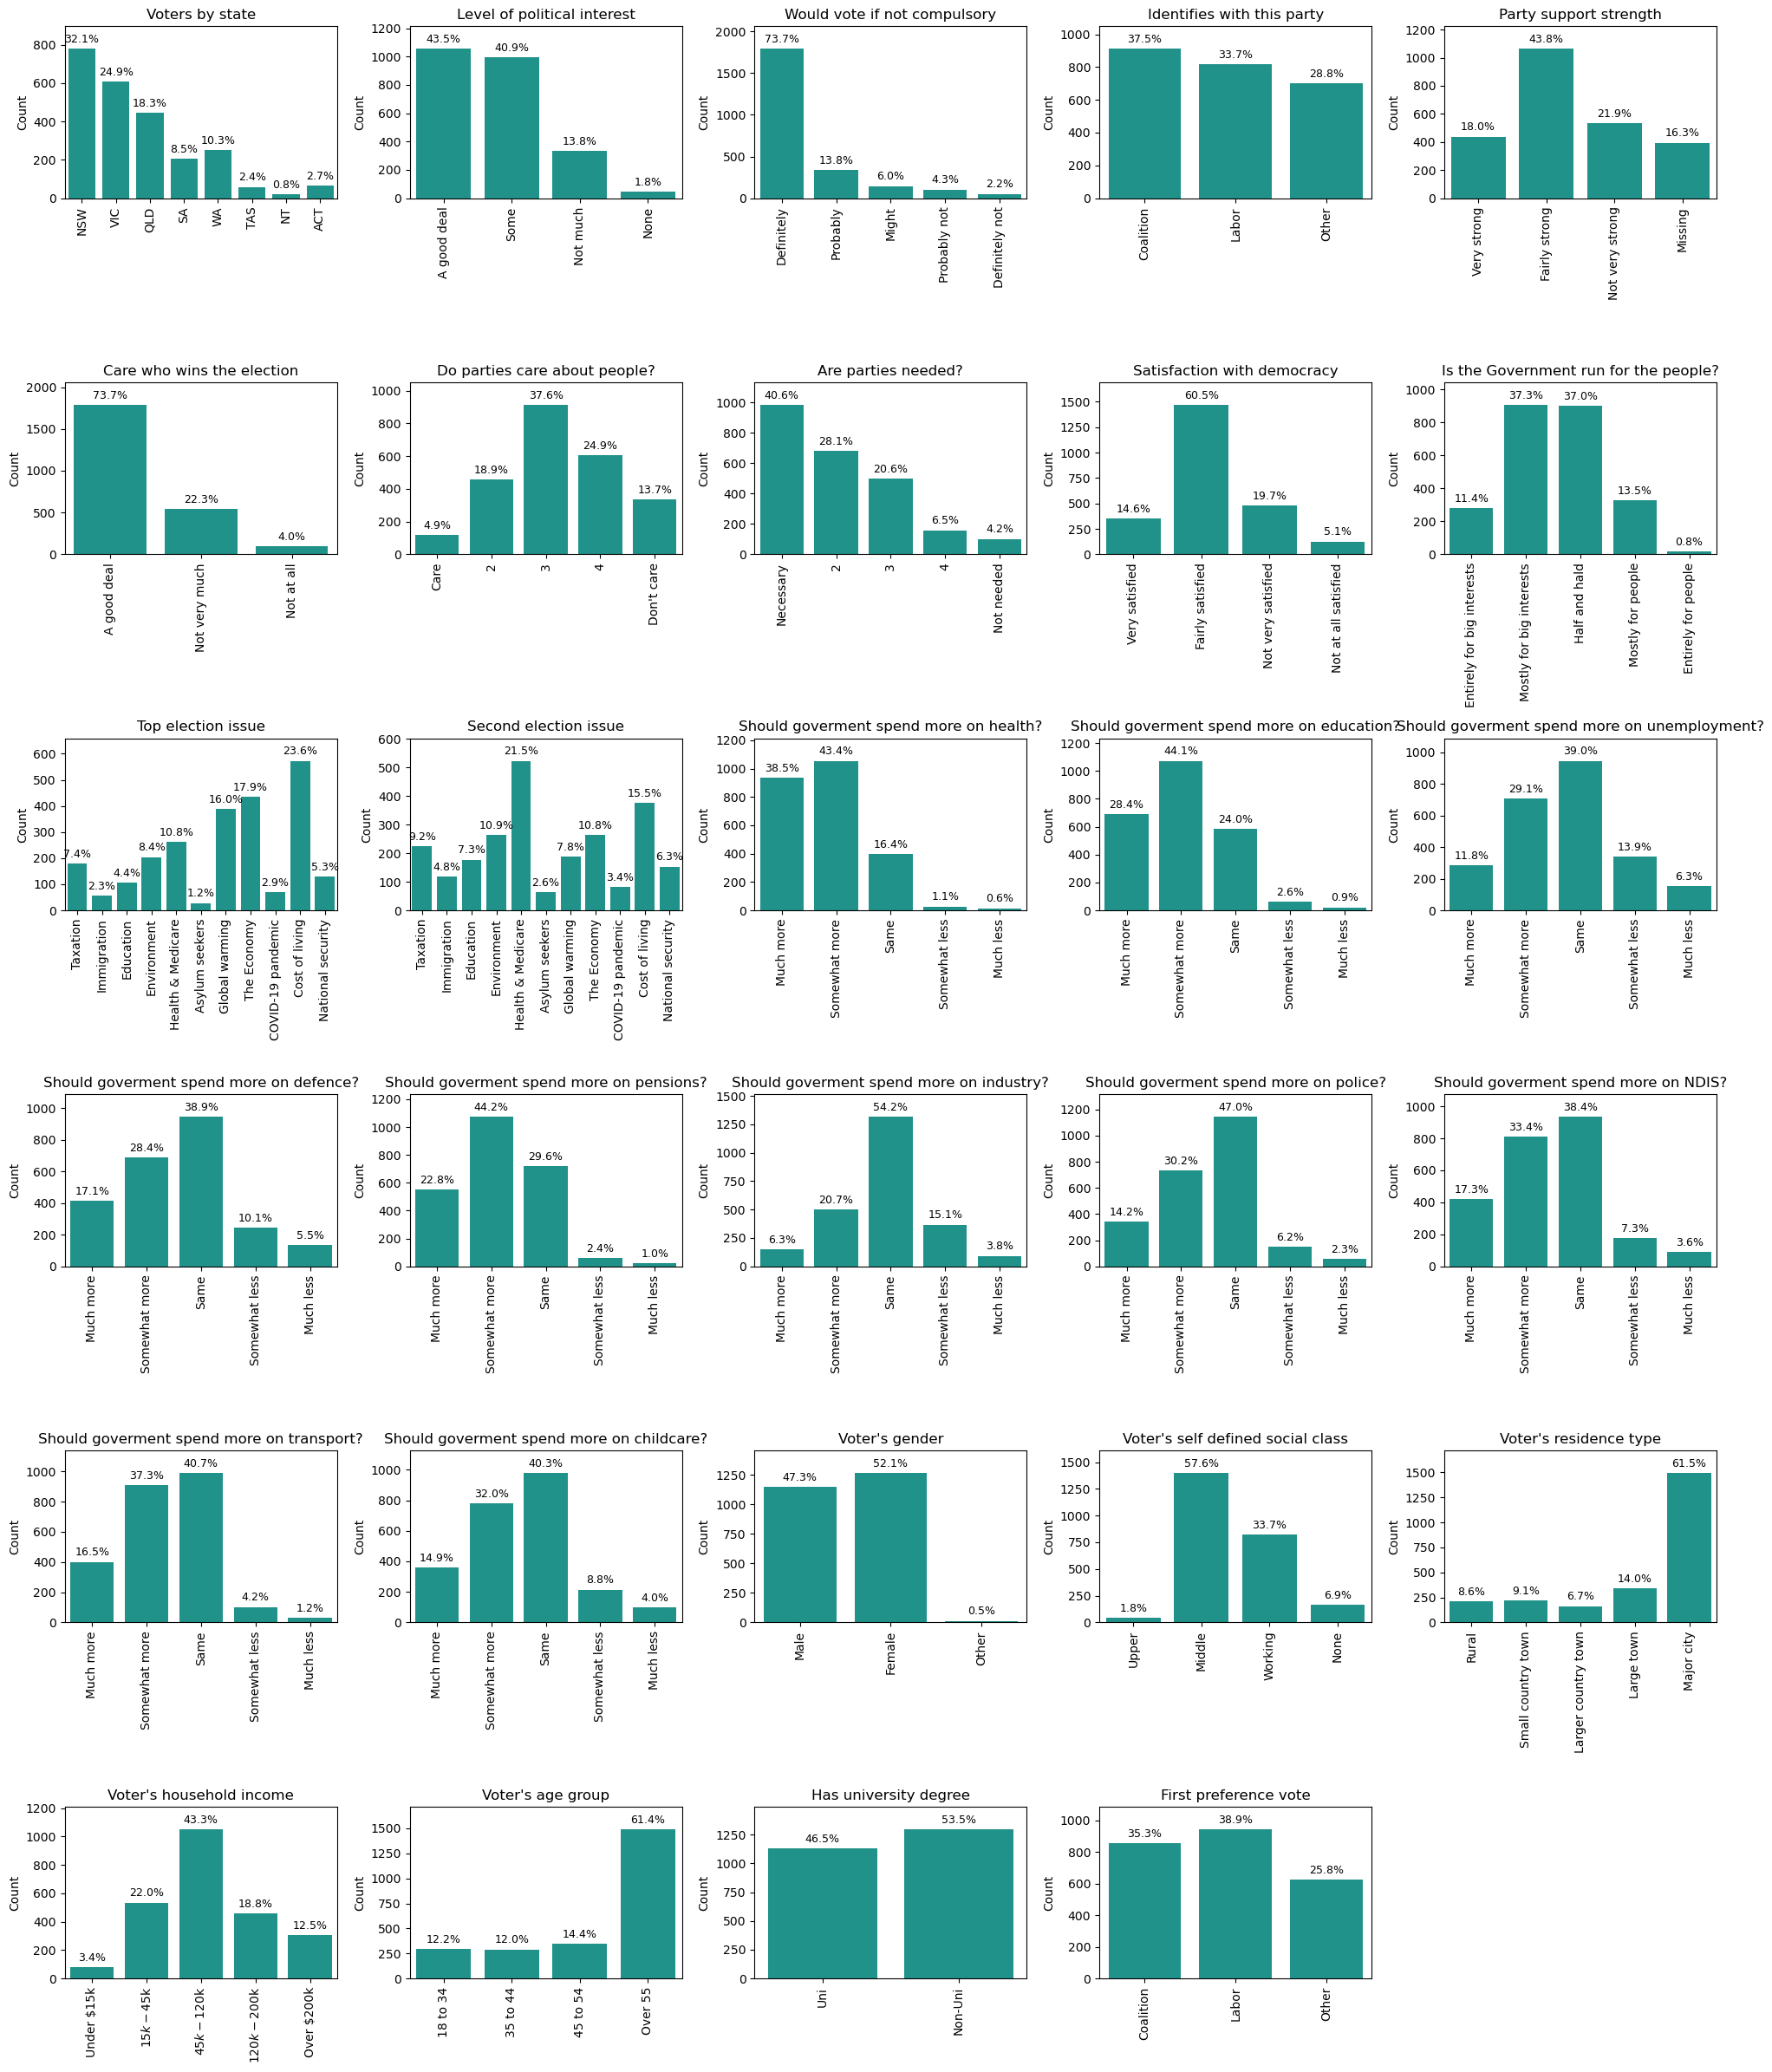

In [19]:
# Countplots for all features

fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 24))
axs = axs.flatten()

columns_to_plot = data.columns

for i, column in enumerate(columns_to_plot):
    plot_counts(
        data=data,
        column=column,
        labels_dict=labels_dict,
        ax=axs[i],
        title=titles[i]
    )

# Remove unused axes
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


## 1.4 Bivariate data analysis

When dealing with numeric variables, we typically turn to Pearson’s and Spearman’s Correlation to gauge the strength and nature of these relationships. However, the terrain changes when we encounter categorical data. Enter Cramer’s V – an effect size (ES) metric that quantifies the overall associations within a contingency table’s rows and columns.

It categorizes results into the following buckets: an 𝐸𝑆≤0.2 signifies a weak connection, 0.2<𝐸𝑆≤0.6 suggests a moderate one, and an 𝐸𝑆>0.6 points to a strong association. To bring these insights to life, we often turn to the trusty heatmap, visually representing Cramer’s V results and illuminating the intricate web of associations in our data. ( from https://rpubs.com/tborges81/cramersv_heatmap)

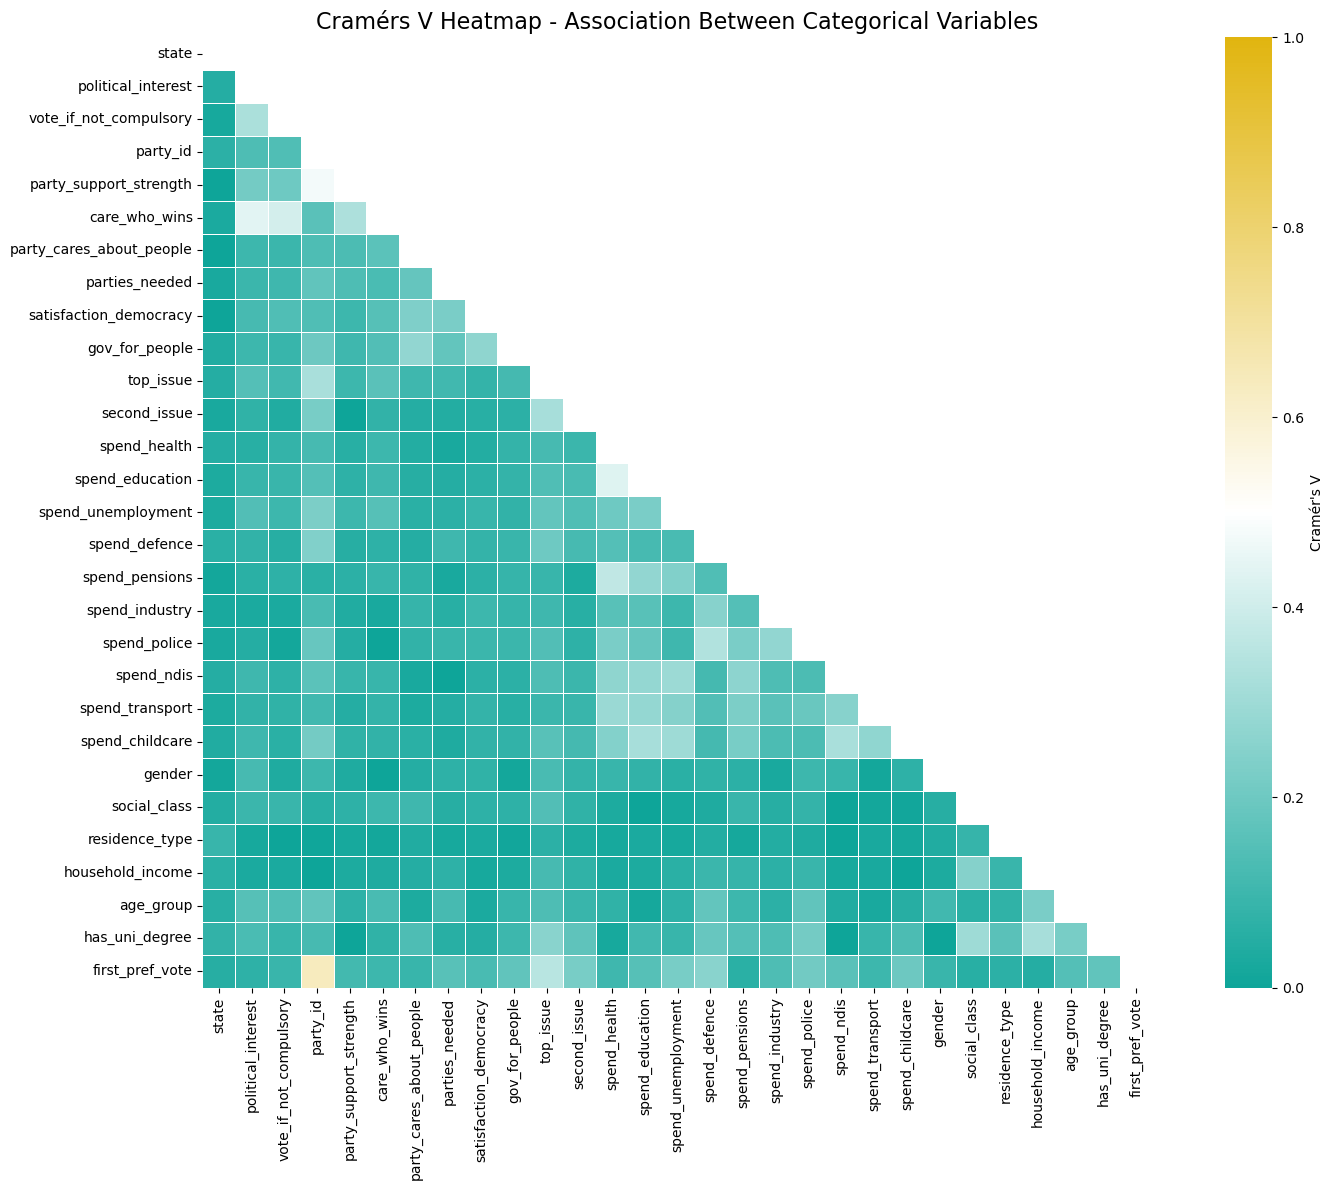

In [20]:
# Function to calculate Cramér’s V

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association between variables x and y."""

    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan  # Avoid calculating for degenerate cases
    
    chi2 = chi2_contingency(confusion_matrix)[0] # calculates the chi squared statistic
    n = confusion_matrix.sum().sum() # total number of observations
    phi2 = chi2 / n   # calculates the phi squared statistic
    r, k = confusion_matrix.shape

    # Bias correction

    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    r_corr = r - ((r - 1)**2) / (n - 1)
    k_corr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

# Compute Cramér’s V matrix

columns = data.columns
cramers_matrix = pd.DataFrame(index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        cramers_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])  # computes Cramér's V for each pair of columns

cramers_matrix = cramers_matrix.astype(float)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cramers_matrix, dtype=bool))

# Plot the heatmap
custom_cmap = LinearSegmentedColormap.from_list(None, [custom_palette[1], "white", custom_palette[2]]) # define custom colormap

plt.figure(figsize=(16, 12))
sns.heatmap(cramers_matrix, 
            cmap=custom_cmap, 
            annot=False,
            mask=mask, 
            vmax=1,
            square=True,
            cbar_kws={"label": "Cramér's V"},
            linewidths=0.5)

plt.title("Cramérs V Heatmap - Association Between Categorical Variables", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [21]:
# Use chi-squared test to find significant features with respect to first preference vote

# create dictionary to store p-values
significance = {}

for col in data.columns:
    if col != 'first_pref_vote':
        contingency = pd.crosstab(data[col], data['first_pref_vote'])
        chi2, p, _, _ = chi2_contingency(contingency)
        significance[col] = p

significance_df = pd.Series(significance).sort_values()
print(significance_df) # features with p-value < 0.05 are significant

party_id                     0.000000e+00
top_issue                   1.278066e-120
spend_defence                1.284401e-64
spend_unemployment           1.448663e-48
spend_police                 1.109710e-43
second_issue                 9.646305e-43
spend_childcare              1.255514e-37
gov_for_people               5.570565e-29
spend_ndis                   1.156218e-24
parties_needed               2.293843e-22
spend_education              2.711251e-21
age_group                    6.432854e-21
has_uni_degree               5.080994e-17
spend_industry               5.996854e-17
satisfaction_democracy       2.266945e-15
party_support_strength       9.331432e-13
care_who_wins                8.029686e-11
spend_health                 6.153774e-10
spend_transport              3.734118e-09
gender                       4.517035e-09
vote_if_not_compulsory       1.391788e-07
party_cares_about_people     1.845479e-07
political_interest           5.222425e-05
residence_type               6.011

Note: All features proved to be statistically significant

In [22]:
# Create a contingency or two-way table table and visualise it as stacked bar chart

def plot_stacked_bars(data, column, target, labels_dict, ax, title):
    """ Plots a bar chart of column showing proportions of target variable with appropriate labels from labels_dict with title and on axis ax."""
    
    # Cross-tabulate and normalize row-wise to get proportions
    crosstab = pd.crosstab(data[column], data[target], normalize='index')

    # Sort by original column order
    crosstab = crosstab.sort_index()

    # Use label maps if provided
    col_labels = labels_dict.get(column, {})
    target_labels = labels_dict.get(target, {})

    # Relabel rows and columns of contingency table for better display
    crosstab.index = crosstab.index.map(lambda x: col_labels.get(x, str(x)))
    crosstab.columns = [target_labels.get(x, str(x)) for x in crosstab.columns]

    custom_cmap = LinearSegmentedColormap.from_list(None, [custom_palette[1], custom_palette[3], custom_palette[2]]) # define custom colormap

    # Plot
    crosstab.plot(kind='bar', stacked=True, ax=ax, colormap=custom_cmap, edgecolor='black', legend=False)
    ax.set_title(title)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")



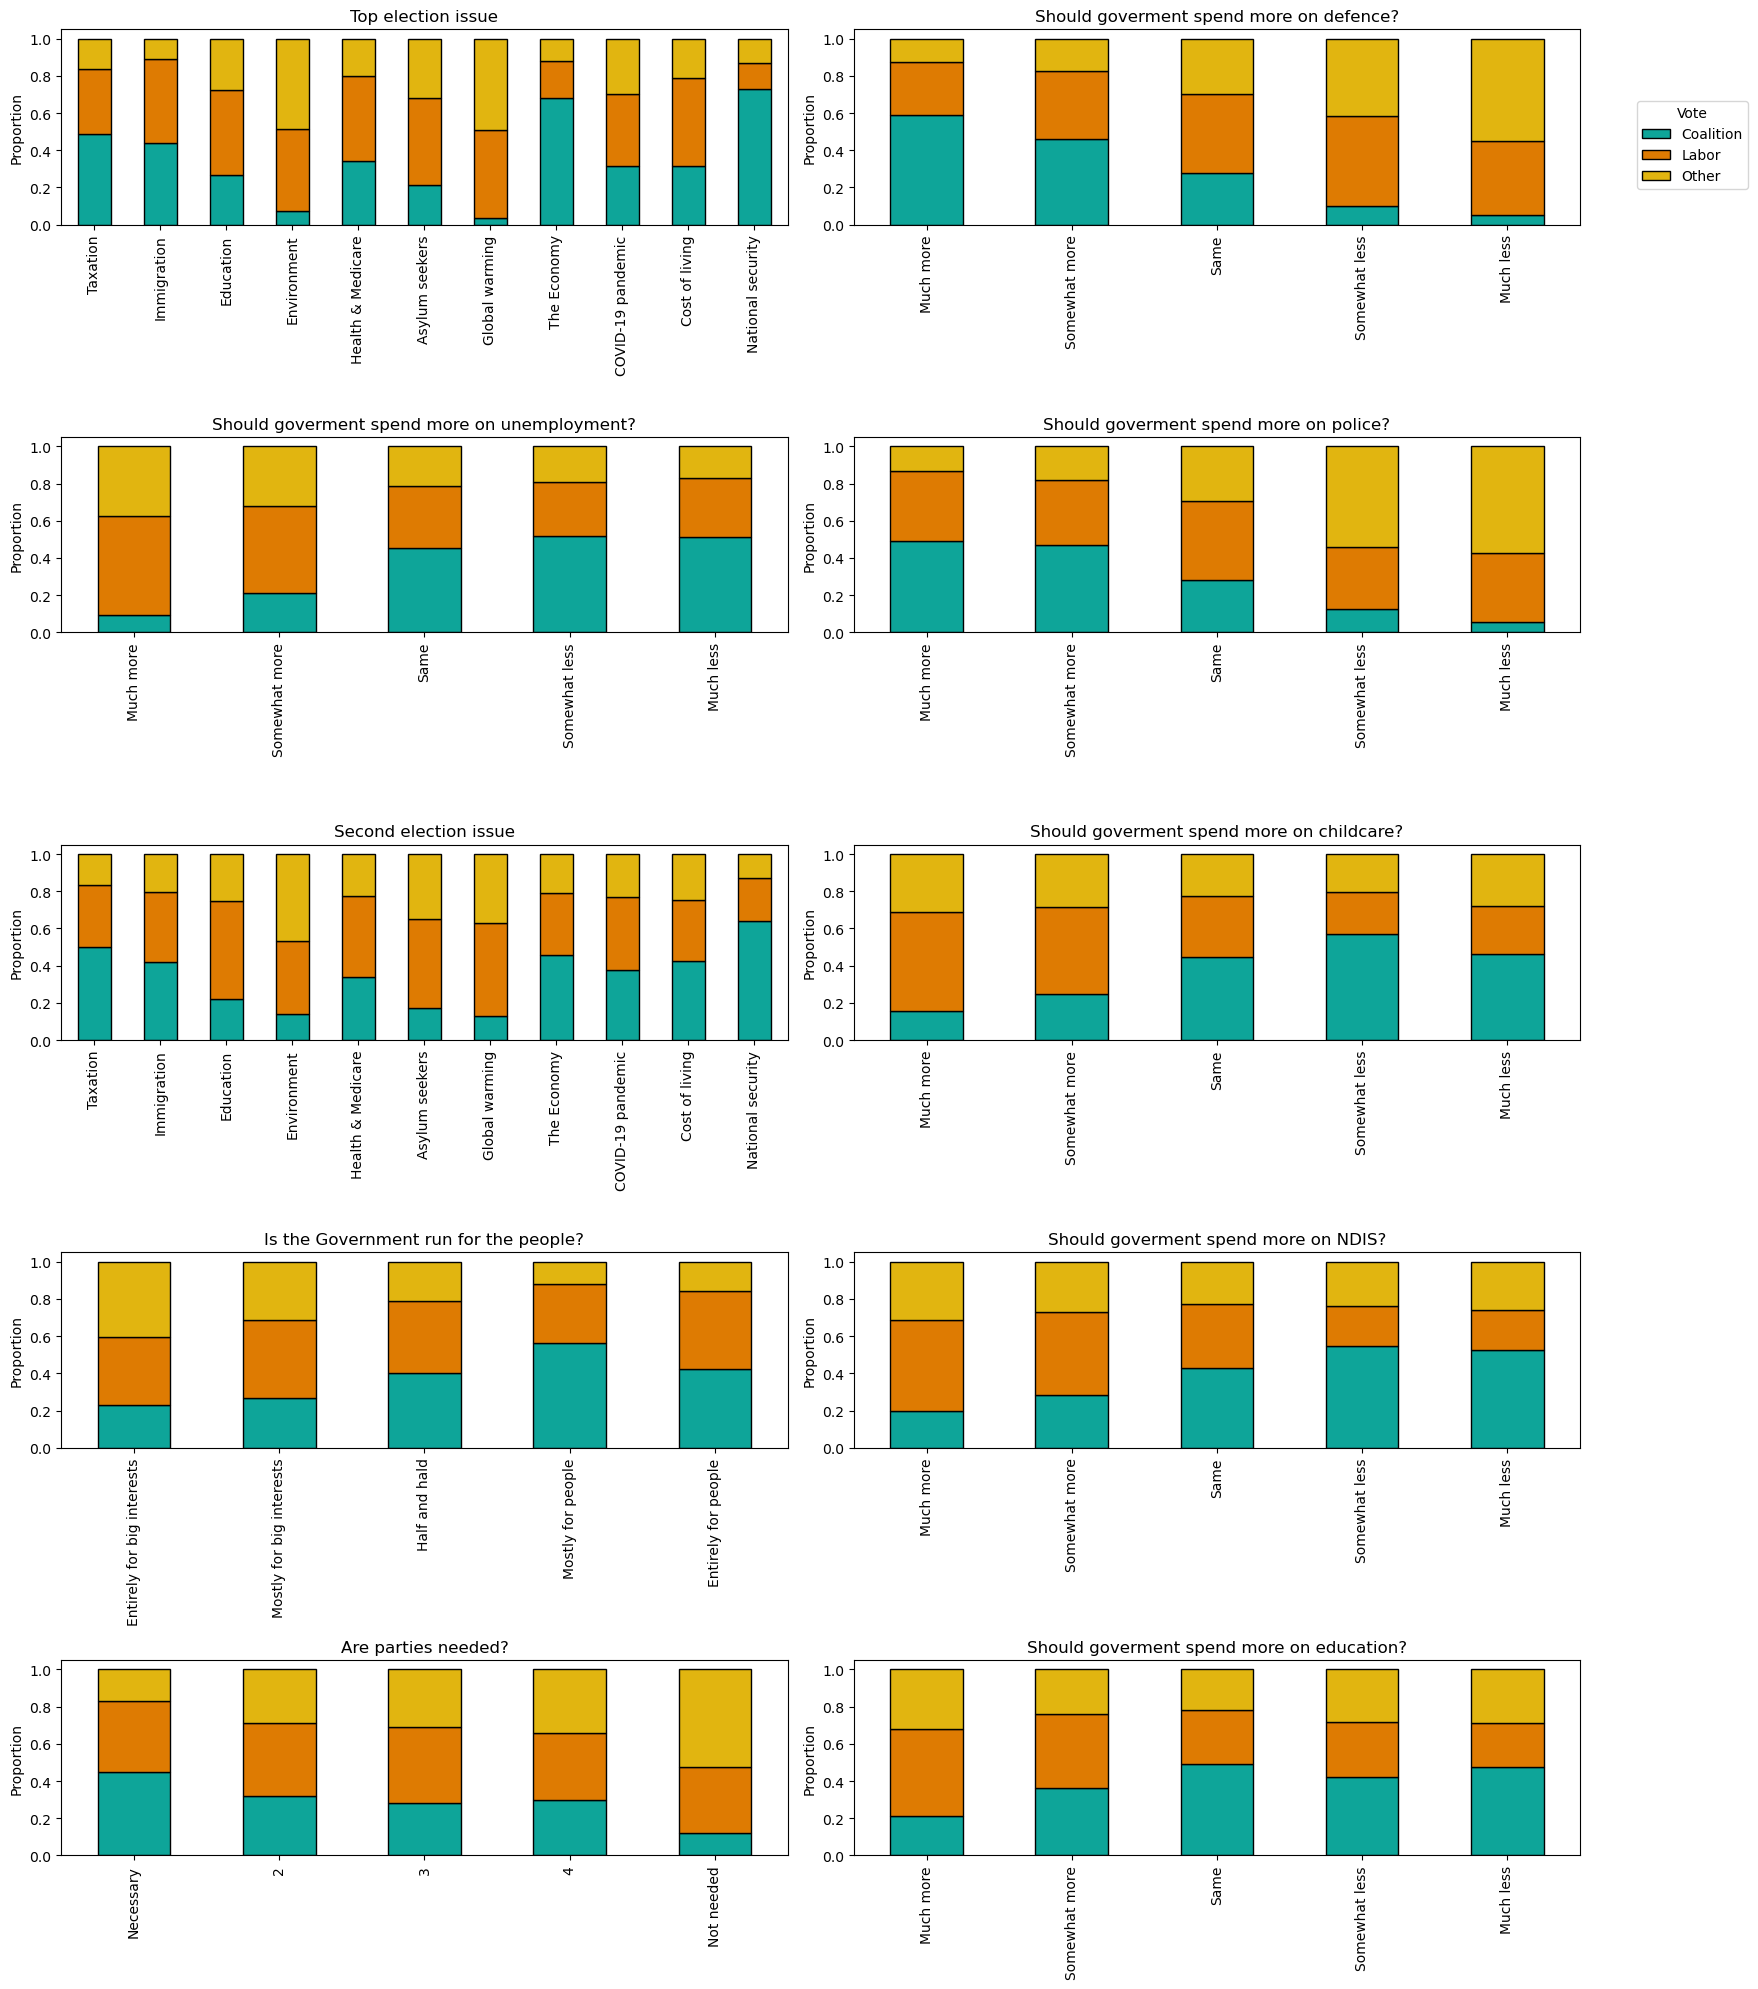

In [23]:
# Use plot_stacked_bars to investigate the most significant features with respect to first preference vote

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
axs = axs.flatten()

# Get top 10 features by significance
top_features = significance_df.sort_values().head(11).index.tolist()[1:]  # skip 'party_id'

for i, feature in enumerate(top_features):
    plot_stacked_bars(
        data=data,
        column=feature,
        target='first_pref_vote',
        labels_dict=labels_dict,
        ax=axs[i],
        title=titles[data.columns.get_loc(feature)]   # retrieves index of feature in top_features and uses it to get the title
    )

# Move legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.95), title='Vote'
)
# Adjust layout
plt.subplots_adjust(right=0.85)  # Adjust right margin to fit legend

plt.tight_layout()
plt.show()


## 1.5 Grouping and aggregates

In [24]:
features_to_breakdown = ['age_group', 'gender', 'household_income', 'residence_type', 
                         'social_class','has_uni_degree', 'political_interest'] 

for feature in features_to_breakdown:
    # Create normalized crosstab
    crosstab = pd.crosstab(data['first_pref_vote'], data[feature], normalize='index')

    # Map row and column labels
    crosstab.index = crosstab.index.map(labels_dict['first_pref_vote'])
    crosstab.columns = [labels_dict[feature].get(val, val) for val in crosstab.columns]

    # Title for clarity
    display_title = f"Distribution of {feature.replace('_', ' ').title()} by First Preference Vote"
    print(display_title)

    # Styled display
    display(
        crosstab.style.format("{:.1%}").background_gradient(cmap=custom_cmap, axis=1)
    )


Distribution of Age Group by First Preference Vote


,18 to 34,35 to 44,45 to 54,Over 55
first_pref_vote,,,,
Coalition,7.0%,8.5%,12.8%,71.6%
Labor,11.8%,11.8%,14.9%,61.4%
Other,19.9%,16.9%,15.6%,47.5%


Distribution of Gender by First Preference Vote


,Male,Female,Other
first_pref_vote,,,
Coalition,54.6%,45.3%,0.1%
Labor,43.4%,56.3%,0.2%
Other,43.2%,55.2%,1.6%


Distribution of Household Income by First Preference Vote


,Under $15k,$15k-$45k,$45k-$120k,$120k-$200k,Over $200k
first_pref_vote,,,,,
Coalition,2.9%,24.0%,45.2%,16.7%,11.2%
Labor,3.5%,23.5%,41.4%,19.6%,12.1%
Other,3.8%,17.1%,43.7%,20.4%,15.0%


Distribution of Residence Type by First Preference Vote


,Rural,Small country town,Larger country town,Large town,Major city
first_pref_vote,,,,,
Coalition,10.4%,11.0%,7.5%,14.9%,56.2%
Labor,7.9%,8.2%,7.1%,15.1%,61.6%
Other,7.3%,8.0%,5.1%,11.0%,68.6%


Distribution of Social Class by First Preference Vote


,Upper,Middle,Working,None
first_pref_vote,,,,
Coalition,1.4%,58.8%,34.2%,5.6%
Labor,1.8%,54.9%,37.0%,6.3%
Other,2.4%,60.0%,28.2%,9.4%


Distribution of Has Uni Degree by First Preference Vote


,Uni,Non-Uni
first_pref_vote,,
Coalition,35.5%,64.5%
Labor,49.4%,50.6%
Other,57.4%,42.6%


Distribution of Political Interest by First Preference Vote


,A good deal,Some,Not much,None
first_pref_vote,,,,
Coalition,41.1%,43.9%,13.9%,1.2%
Labor,47.3%,40.2%,11.1%,1.5%
Other,41.0%,38.1%,17.7%,3.2%


## Comments:
- Data has 29 features and 2508 samples which were reduced to 2430 after dropping the non-voters and rows with too many missing values. Most features are categorical or ordinal Likert scales, which influenced how visualisations and statistical summaries were conducted.

- Some missing values in all columns except for state. Lower counts of missing values were replaced with the mode for categorical variables and with the median for ordinal variables. Higher counts of missing values in party_support_strength were replaced with "missing" to include them in the study, whilst missing values in household_income were replaced with the median when grouped by age_group, has_uni_degree and social_class.

- Features party_id and first_pref_vote were re-mapped to show only three options: The Coalition (Liberals and Nationals), Labor and Other (Independents and minor parties). Feature household_income was re-mapped from 13 down to 5 income brackets more aligned with the brackets in the 2021-22 income tax table.

- Percentage of voters per state in the dataset is representative of the percentage of people per state in Australia. 

- 84.4% of respondents are very engaged or engaged with politics with 73.7% definitely voting if it wasn't compulsory and caring a good deal about who wins the election. Political engagement is a good indicator of the health of democracy.

- 71.2 percent of voters identify themselves as either Coalition or Labor but only 61.8 percent indicated a very or fairly strong support for their party. Although more voters identify themselves with the Coalition (37.5%) than Labor (33.7%), Labor got more first preference votes (38.9%) than the Coalition (35.3%) at the 2022 election, indicating that many Coalition voters were not happy with the performance of the Coalition government of the time.

- Only about 23.8% of voters believe that parties care about people, but 68. 7% believes in the party system. 75.1% of voters are satisfied with democracy but 48.7% believes the government is run mostly or entirely for big interests instead of the people.

- Issues that these voters are more concerned about are cost of living, health, the economy and global warming. And they believe the government should spend more in health, education and pensions.

- The dataset includes slightly more female (52.1%) than male (47.3%) voters, and 61.5% of respondents live in major cities. Notably, 61.4% of voters in the sample are over 55 years old, while Australians in this age group make up roughly 36% of the adult population according to ABS data — indicating a strong overrepresentation of older voters. In contrast, only 12.2% of the sample are aged 18 to 34, despite this group comprising approximately 27% of the Australian adult population. This suggests the dataset is biased toward older individuals.

- 57.6% of participants identify themselves as middle class and 33.7% as working class, with 46.5% having a university degree and 43.3% in the middle income bracket.

- Cramers V heatmap showed a strong association between target variable first_pref_vote and party_id as it would be expected. party_id will be used in the clustering analysis but will be dropped before modelling to avoid data leakage. Variables that showed a moderate association between each other are: party_id and party_support_strength, spend_education and spend_health, care_who_wins and political_interest, care_who_wins and vote_if_not_compulsory.

- Using chi-squared test and p-values to determine which features were statistically significant with respect to first_pref_vote returned all features as statistically significant (p<0.05). With the top ten features being: party_id, top_issue, spend_defence, spend_unemployment, spend_police, second_issue, spend_childcare, gov_for_people, spend_ndis and parties_needed.

- Coalition voters tended to rank the economy and national security as their top issues, whilst Labor voters tended to rank a wider range of issues equally high: health, education, global warming, environment, cost of living, immigration and asylum seekers. Other voters ranked global warming and the environment as their main issues.

- Coalition voters tend to think that the government is mostly run for the people, whilst Labor and Other voters feel that is run mostly or entirely for big interests.

- Younger age groups have higher proportions of Labor and Other voters (11.8% and 19.9% vs 7%), whilst older age groups have higher proportions of Coalition and Labor voters (71.6% and 61.4% vs 47.5%). 

- Female voters tend to vote more for Labor and Other (56.3% and 55.2% vs 45.3%) whilst male voters tend to vote more for the Coalition (54.6% vs 43.4% and 43.2%).

- In rural areas and small country towns there are higher proportions of Coalition voters (21.4% vs 16.1% and 15.3%) whilst in Major cities there were higher proportions of Labor and Other voters (61.6% and 68.6% vs 56.2%). 

- People with university degrees voted more for Labor and Other (49.4% and 57.4% vs 35.5%) whilst people without degrees voted more for the Coalition (64.5% vs 50.6% and 42.6%).
